<a href="https://colab.research.google.com/github/jgait/DSPS_WGaither/blob/main/HW6/Gaither_Mckennedy_DSPS_gaussian_process_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.datasets import elnino

!pip install george
import george
from george import kernels

!pip install icecream
from icecream import ic

import warnings
#warnings.filterwarnings('ignore')

import plotly.graph_objects as go
plt.style.use('seaborn-v0_8')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for george: filename=george-0.4.0-cp310-cp310-linux_x86_64.whl size=355559 sha256=28876fc0fc90cf3222a11cd7daf7b742ccf9d968755f4a8ba85337daef4c0af6
  Stored in directory: /root/.cache/pip/wheels/63/02/e3/24f2361717de09616769d97ed5854b4703d4df49fb1a3a1131
Successfully built george


# NB

Code skeletons are provided for you, but you may change them as you please.

It is not required, but I suggest you adjust and complete the given docstrings as you make changes.

# 0. The Dataset

We'll be using the El Niño dataset from the `statsmodels` package. This first cell of code loads the dataset easily for you. Read the description of the dataset [here](https://www.statsmodels.org/devel/datasets/generated/elnino.html).

In [ ]:
def load_elnino_dataset():
    """
    Downloads the El Niño dataset from the statsmodels package.

    Parameters
    ----------
    None

    Returns
    -------
    df : pd.DataFrame
        A Pandas dataframe containing the raw data of the El Niño dataset
        directly from the statsmodels package.
    """
    df = elnino.load_pandas().data
    return df

df = load_elnino_dataset()
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1950.0,23.11,24.20,25.37,23.86,23.03,21.57,20.63,20.15,19.67,20.03,20.02,21.80
1,1951.0,24.19,25.28,25.60,25.37,24.79,24.69,23.86,22.32,21.44,21.77,22.33,22.89
2,1952.0,24.52,26.21,26.37,24.73,23.71,22.34,20.89,20.02,19.63,20.40,20.77,22.39
3,1953.0,24.15,26.34,27.36,27.03,25.47,23.49,22.20,21.45,21.25,20.95,21.60,22.44
4,1954.0,23.02,25.00,25.33,22.97,21.73,20.77,19.52,19.33,18.95,19.11,20.27,21.30


In [ ]:
def to_dtm(year, month):
  """
  Takes the year (Eg. 1950.0) and month (Eg. JAN) and converts to pandas datetime.
  Note: 1st day is selected for the date

  Parameters
  ----------
  year : numeric year
      The year to be converted
  month : string month
      The month to be converted

  returns
  -------
  Date as pandas datetime
  """
  year = int(year)
  num_month = {'JAN': 1,
              'FEB': 2,
              "MAR": 3,
              "APR": 4,
              "MAY": 5,
              "JUN": 6,
              "JUL": 7,
              "AUG": 8,
              "SEP": 9,
              "OCT": 10,
              "NOV": 11,
              "DEC": 12,}[month]

  return pd.to_datetime(f"{year}-{num_month}")


In [ ]:
def flatten_dataset(df):
    """
    Flatten the data in the dataframe.

    The sea surface temperature data is stored in a somewhat peculiar way in
    this dataset. The data has rows for every year between 1950 and 2010, and
    it has 12 columns for each month of each year.

    Re-order the data such that there is one 1-dim array for the temperature data.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    flattened_df : pd.DataFrame
        The elnino data flattened to a (732,2) pandas dataframe
    """
    time = np.zeros((732,), dtype=object)
    data = np.zeros((732,))

    def parse_data(x):
      """
      Take the dataframe row, extract month and year, convert to datetime
      write time and data to correct cell of time and data arrays
      """
      labels = x.axes[0]
      year = x["YEAR"]
      row_ind = year - 1950
      for label in labels[1:]:
        month = label
        elmnt_data = x[month]
        series_ind = x.index.get_loc(label) - 1
        target_ind = int(row_ind * 12 + series_ind)
        time[target_ind] = to_dtm(year, month)
        data[target_ind] = elmnt_data

    df.apply(parse_data, axis=1)

    flattened_df = pd.DataFrame({'TIME':time, 'TEMP':data})

    return flattened_df

flat = flatten_dataset(df)
ic(flat.shape)
flat.head()
flat['TIME'].dt.year

ic| flat.shape: (732, 2)


0      1950
1      1950
2      1950
3      1950
4      1950
       ... 
727    2010
728    2010
729    2010
730    2010
731    2010
Name: TIME, Length: 732, dtype: int64

In [ ]:
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1950.0,23.11,24.20,25.37,23.86,23.03,21.57,20.63,20.15,19.67,20.03,20.02,21.80
1,1951.0,24.19,25.28,25.60,25.37,24.79,24.69,23.86,22.32,21.44,21.77,22.33,22.89
2,1952.0,24.52,26.21,26.37,24.73,23.71,22.34,20.89,20.02,19.63,20.40,20.77,22.39
3,1953.0,24.15,26.34,27.36,27.03,25.47,23.49,22.20,21.45,21.25,20.95,21.60,22.44
4,1954.0,23.02,25.00,25.33,22.97,21.73,20.77,19.52,19.33,18.95,19.11,20.27,21.30


# 1. Visualize

<ipython-input-6-c2708fb8b15b>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  decade_df = decade_df[flat['TIME'].dt.year < max]
<ipython-input-6-c2708fb8b15b>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  decade_df = decade_df[flat['TIME'].dt.year < max]
<ipython-input-6-c2708fb8b15b>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  decade_df = decade_df[flat['TIME'].dt.year < max]
<ipython-input-6-c2708fb8b15b>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  decade_df = decade_df[flat['TIME'].dt.year < max]
<ipython-input-6-c2708fb8b15b>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  decade_df = decade_df[flat['TIME'].dt.year < max]


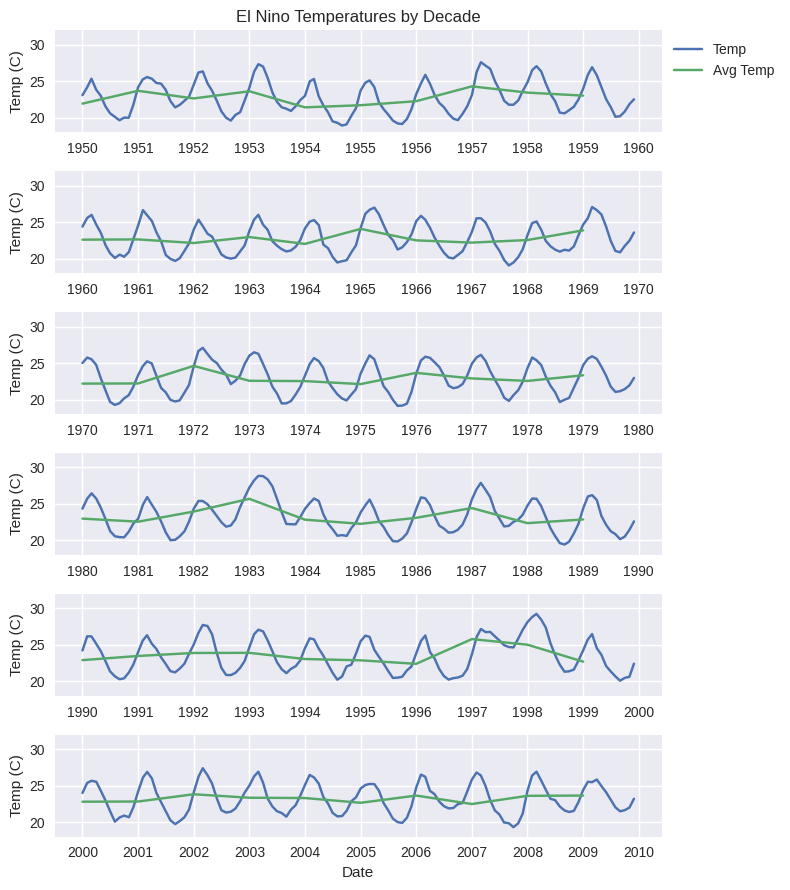

Figure 1: This set of plots shows the temperature throughout the year as well as the average temperature per year split up by decade for easier viewing


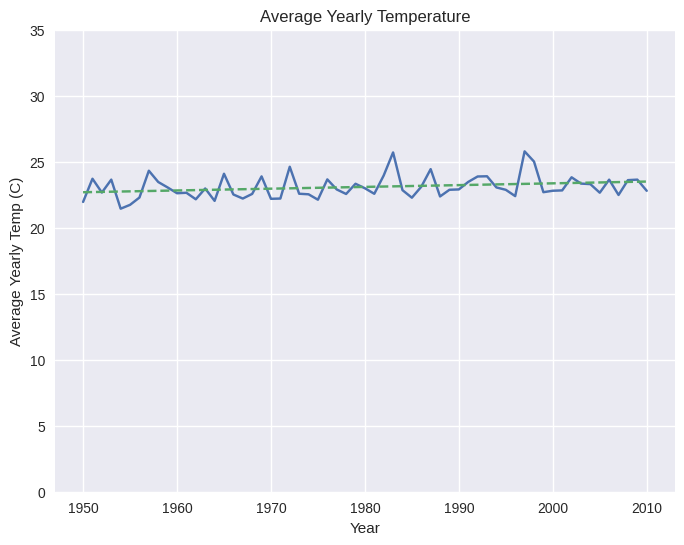


Figure 2:
   Here, the average yearly temperature is plotted and an L2 best linear regression is applied in order to reveal
   any trend in the data. Sure enough, the fit returns a line with a slope of 0.0135 C°/year indicating gradual warming. We will
   watch out for this positive slope in the gaussian process regression

Figure 3:
   This plot creates a surface with x and y as year and month and then temperature in Z.
   Visualizing this way allows us to quickly notice hot years and cold years and lets us observe the data along multiple axes.
   Sliders are also included in order to allow for limiting of the data ranges, permitting us to view the series for a single year,
   or for the same month over all the years, or anywhere in between. Some interesting things that jump out when looking at this
   visualization are that 1998 and 1993 (as well as a few interveneing years) were exceptionally hot years as well as the fact that 
   that overall the temperature is somewhat cyclical, 

In [ ]:
from pandas._libs.tslibs.offsets import YearBegin
def visualize(df):
    """
    Visualize the El Niño – Sea Surface Temperature dataset.

    You decide the most appropriate way to visualize the dataset.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    None
    """
    flat = flatten_dataset(df)

    # Plot by decade with average
    fig, ax = plt.subplots(6,1, figsize=(8,9))

    for decade in range(6):
      min = 1950 + decade * 10
      max = 1950 + decade * 10 + 10
      decade_df = flat[flat['TIME'].dt.year >= min]
      decade_df = decade_df[flat['TIME'].dt.year < max]
      ax[decade].plot(decade_df['TIME'], decade_df['TEMP'], label = 'Temp')

      # Compute and add the yearly average
      decade_df['YEAR'] = decade_df['TIME'].dt.year
      avgs = pd.DataFrame(columns=['TEMP'])
      avgs['TEMP'] = decade_df.groupby('YEAR')['TEMP'].mean()
      avgs.index.name = 'year'
      avgs = avgs.reset_index()
      avgs['month'] = 1
      avgs['day'] = 1
      avgs['TIME'] = pd.to_datetime(avgs[['day', 'month', 'year']])
      ax[decade].plot(avgs['TIME'], avgs['TEMP'], label='Avg Temp')

      # Style that shiz
      ax[decade].set_ylabel('Temp (C)')
      ax[decade].set_ylim(18, 32)
      if decade == 5:
        ax[decade].set_xlabel('Date')
      if decade == 0:
        ax[decade].set_title("El Nino Temperatures by Decade")
        ax[decade].legend(loc='upper left', bbox_to_anchor=(1,1))

    plt.tight_layout()
    plt.show()

    print("Figure 1: This set of plots shows the temperature throughout the year as well as the average temperature per year split up by decade for easier viewing")

    # ===== Plot the average yearly temps =====
    flat['year'] = flat['TIME'].dt.year
    yearly_avg = flat.groupby('year')['TEMP'].mean()

    fit = np.polyfit(yearly_avg.index.to_list(), yearly_avg, 1)

    fig2, ax = plt.subplots(1,1, figsize = (8,6))
    ax.plot(yearly_avg)
    ax.plot(np.unique(yearly_avg.index.to_list()),
            np.poly1d(fit)(np.unique(yearly_avg.index.to_list())),
            linestyle='--')
    ax.set_ylabel('Average Yearly Temp (C)')
    ax.set_xlabel('Year')
    ax.set_title('Average Yearly Temperature')
    ax.set_ylim(0, 35)
    plt.show()

    print('\nFigure 2:\n   Here, the average yearly temperature is plotted and an L2 best linear regression is applied in order to reveal\n  ',
          f'any trend in the data. Sure enough, the fit returns a line with a slope of {fit[0]:0.4f} C°/year indicating gradual warming. We will\n   watch out for this positive slope in the gaussian process regression')
"""
    # ===== Plot the temps as a surface with x as year, y as month and z as temperature =====
    X = df['YEAR']
    Y = df.columns.tolist()[1:]
    Y_num = [1,2,3,4,5,6,7,8,9,10,11,12]
    Z = df.loc[:, df.columns != 'YEAR'].to_numpy()

    XX, YY = np.meshgrid(X, Y, indexing="ij")
    XX_num, YY_num =  np.meshgrid(X, Y_num, indexing="ij")

    fig3 = go.Figure()
    #fig3.add_surface(z=Z, x=XX, y=YY_num, colorscale='bluered', opacity=1)
    fig3.add_surface(z=Z, x=XX, y=YY_num, colorscale='jet', opacity=1)

    for xx, yy, zz in zip(XX_num, YY_num, Z+0.03):
      fig3.add_scatter3d(x=xx, y=yy, z=zz,
                          mode='lines',
                          opacity=1,
                          marker=dict(size=5, color='grey'),
                          name = '')

    XX_num, YY_num =  np.meshgrid(Y_num, X, indexing="ij")
    Zt = Z.T

    for xx, yy, zz in zip(XX_num, YY_num, Zt + 0.03):
      fig3.add_scatter3d(x=yy, y=xx, z=zz,
                          mode='lines',
                          opacity=1,
                          marker=dict(size=5, color='grey'),
                          name = '')


    sliders=[
        # X-axis Upper Bound Slider
        dict(
            steps=[
                dict(method='relayout', args=['scene.xaxis.range[1]', val], label=str(val))
                for val in range(1950, 2011)
            ],
            active=60,
            currentvalue=dict(font=dict(size=12), prefix='X-axis Upper Bound: ', visible=True, xanchor='right'),
            len=0.45,
            x=0,
            y=-0.0,
        ),
        # Y-axis Upper Bound Slider
        dict(
            steps=[
                dict(method='relayout', args=['scene.yaxis.range[1]', val], label=str(val))
                for val in range(1, 13)
            ],
            active=11,
            currentvalue=dict(font=dict(size=12), prefix='Y-axis Upper Bound: ', visible=True, xanchor='right'),
            len=0.45,
            x=0.5,
            y=-0.0,
        ),
        # X-axis Lower Bound Slider
        dict(
            steps=[
                dict(method='relayout', args=['scene.xaxis.range[0]', val], label=str(val))
                for val in range(1950, 2011)
            ],
            active=1,
            currentvalue=dict(font=dict(size=12), prefix='X-axis Lower Bound: ', visible=True, xanchor='right'),
            len=0.45,
            x=0,
            y=-0.2,
        ),
        # Y-axis Lower Bound Slider
        dict(
            steps=[
                dict(method='relayout', args=['scene.yaxis.range[0]', val], label=str(val))
                for val in range(1, 13)
            ],
            active=0,
            currentvalue=dict(font=dict(size=12), prefix='Y-axis Lower Bound: ', visible=True, xanchor='right'),
            len=0.45,
            x=0.5,
            y=-0.2,
        ),
    ]
    fig3.update_layout(title='Surface Plot of Temperatures',
                        autosize=False,
                        width=1000,
                        height=800,
                        scene=dict(
                                aspectratio = dict(x=2, y=1, z=1),
                                yaxis = dict(
                                    title = 'Month',
                                    tickmode = "array",
                                    tickvals = Y_num,
                                    ticktext=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEPT', 'OCT', 'NOV', 'DEC']
                                ),
                                xaxis = dict(
                                    title = 'Year'
                                ),
                                zaxis = dict(
                                    title = 'Temp (C)'
                                )
                            ),
                        sliders=sliders
                        )

    fig3.show()
"""

visualize(df)

print('\nFigure 3:\n   This plot creates a surface with x and y as year and month and then temperature in Z.\n  ',
        'Visualizing this way allows us to quickly notice hot years and cold years and lets us observe the data along multiple axes.\n  ',
        'Sliders are also included in order to allow for limiting of the data ranges, permitting us to view the series for a single year,\n  ',
        'or for the same month over all the years, or anywhere in between. Some interesting things that jump out when looking at this\n  ',
        'visualization are that 1998 and 1993 (as well as a few interveneing years) were exceptionally hot years as well as the fact that \n  ',
        'that overall the temperature is somewhat cyclical, with a couple years of rising temperatures followed by a couple years of falling temperatures')


# 2. Gaussian Process Regression (GPR)

In [ ]:
def get_interpolated_time():
    """
    We are going to use GPR to interpolate the sea surface temperatures for
    every day between January 1st 1950 and December 1st 2030. There are 29,555
    days between those two dates (inclusive). Create and return an array of
    times for each day in that timeframe.

    Paramters
    ---------
    None

    Returns
    -------
    interp_time : array-like
        A shape (29555,) array, the times we want to interpolate. Encoded the
        same way you did before or any way you like.
    """
    date_range = pd.date_range(start='1950-1-1', end='2030-12-1', freq='D')
    return pd.DataFrame(date_range, columns=['interp_time'])

t = get_interpolated_time()
t.head()

,interp_time
0,1950-01-01
1,1950-01-02
2,1950-01-03
3,1950-01-04
4,1950-01-05


0      23.11
1      24.20
2      25.37
3      23.86
4      23.03
       ...  
727    19.49
728    19.28
729    19.73
730    20.44
731    22.07
Name: TEMP, Length: 732, dtype: float64


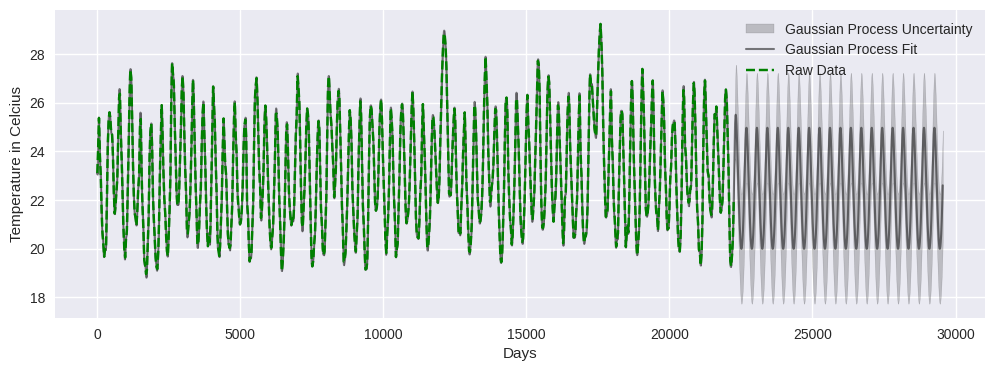

In [ ]:
def gaussian_process_regression(arg_time, arg_data, arg_interp_time, arg_initial_guess):
    """
    Using the george package, its documentation and startup guide, implement a
    gaussian process regressor on `time` and `data`. Then, use it to predict
    on `interp_time`.

    It will be helpful for you to write code to visualize the result of this
    initial model, but not necessary for the assignment.

    Parameters
    ----------
    arg_time : array-like
        A shape (732,) array, times between 1950 and 2010, sampled every month, units in days.
    arg_data : array-like
        A shape (732,) array, sea surface temperatures every month between 1950
        and 2010.
    arg_interp_time : array-like
        A shape (29555,) array, times between 1950 and 2030, sampled every day, units in days.
    arg_initial_guess : array-like or float
        The intial guess for the gaussian process, currently (length scale, period, r_val),
        probably going to change to just r_val

    Returns
    -------
    pred_temp, pred_temp_var (predicted temperature over t_interp and variance on temperature)
    """
    # followed example here: https://george.readthedocs.io/en/latest/tutorials/first/#first

    # Get everything in terms of days

    # ZACH NOTE: Trying to not shift it to see what happens. keeping code here.
    # Center data around 0 by subtracting off the mean (easiest when centered around 0)
    #data_mean =  np.mean(arg_data)
    #arg_data_shifted = arg_data - data_mean


    # This is old but here for posterity (take it away later)
    # Turns out the fit gets better as the period goes up so the expsine2kernel is basically useless
    # Due to the quasi-periodic nature of the dataset, we'll use a periodic kernel multiplied by a squared exponential kernel
    # kernel = np.var(data) * kernels.ExpSine2Kernel(gamma, np.log10(period)) * kernels.ExpSquaredKernel(r_val)
    # Use a squared exponential kernel as it seems to work well
    #kernel = np.var(arg_data_shifted) * kernels.ExpSquaredKernel(r_val)

    # 3rd try is the charm....
    kernel = np.var(arg_data) * kernels.ExpSquaredKernel(arg_initial_guess[1]) + kernels.ExpSine2Kernel(1.0, np.log(initial_guess[0]))

    # Do magic
    gp = george.GP(kernel)
    gp.compute(arg_time, yerr=0)

    pred_temp, pred_temp_var = gp.predict(arg_data, arg_interp_time, return_var=True)

    # Plot stuff in order to see if it is working
    fig, ax = plt.subplots(figsize=(12,4))
    ax.fill_between(arg_interp_time, pred_temp - np.sqrt(pred_temp_var), pred_temp + np.sqrt(pred_temp_var),
                color="k", alpha=0.2)
    ax.plot(arg_interp_time, pred_temp, "k", lw=1.5, alpha=0.5)
    ax.plot(arg_time, arg_data, '--g')

    plt.legend(["Gaussian Process Uncertainty", "Gaussian Process Fit", "Raw Data"])
    plt.xlabel("Days")
    plt.ylabel("Temperature in Celcius")
    plt.show()

    return pred_temp, pred_temp_var


# r_value for the exponential (Hyperparameter for the kernel)
#   We know that a year is ~365 days.
initial_guess = [365, 1800]
# DOES NOT WORK AT ALL IF THE SINE FREQUENCY INITIAL GUESS IS NOT 365 ! ! !

# Get the data set and convert all the units to days
flat = flatten_dataset(df)
t = (flat['TIME'] - pd.to_datetime('1950-01-01')).dt.days
data = flat['TEMP']
print(data)
interp_t = (get_interpolated_time()['interp_time'] - pd.to_datetime('1950-01-01')).dt.days

# add a limit so that we can see what the heck is going on (Take away later)
pred, pred_var = gaussian_process_regression(t, data, interp_t, initial_guess)

# IDK if the predictions are actually working, need to investigate. It does seem to track the training set well tho

**Figure 4:** This plot shows the data for the ocean temperature variation between 1950 and 2010. Then, using the Gaussian Process it is fitting data for 1950 to 2030. The fit matches the data super well but outside the range of the given data it basically just becomes a normal sine wave with no yearly variation which is clearly not a very good representation of what will truly happen....

# 3. Optimize

In [ ]:
from scipy.optimize import minimize

In [ ]:
print(t)

0          0
1         31
2         59
3         90
4        120
       ...  
727    22127
728    22158
729    22188
730    22219
731    22249
Name: TIME, Length: 732, dtype: int64


In [ ]:
initial_guess = [365, 1800]

def optimize(args, t, data, t_interp):
    """
    USING L2!!!!

    Print the results of your optimization.
    """
    # YOUR CODE HERE
    # Initialize Kernal and Gaussian Process.
    kernel = np.var(data) * kernels.ExpSquaredKernel(args[1]) + kernels.ExpSine2Kernel(1.0, np.log(args[0]))
    gp = george.GP(kernel,white_noise = 1)
    gp.compute(t)
    pred, pred_var = gp.predict(data, t_interp, return_var=True)

    # Sum error for days:
    sum = 0
    for i in range(len(t)):
      # Get predicted value at this index:
      preddy = pred[t[i]]
      # Get the REAL value at this index:
      real = data[i]
      # L2 calc:
      l2 = np.square(np.abs(preddy - real))
      # Add it to the sum
      sum += l2
    # Return the summed error...
    return sum

l2Opt = minimize(optimize, initial_guess, args=(t, data, interp_t))
print(l2Opt) # 9 whole minutes to run this shit lmao


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 50.59233107094855
        x: [ 3.652e+02  1.673e+03]
      nit: 15
      jac: [-8.106e-06  4.768e-07]
 hess_inv: [[ 5.212e-02 -3.197e-01]
            [-3.197e-01  1.608e+04]]
     nfev: 189
     njev: 63


# 4. Visualize your model

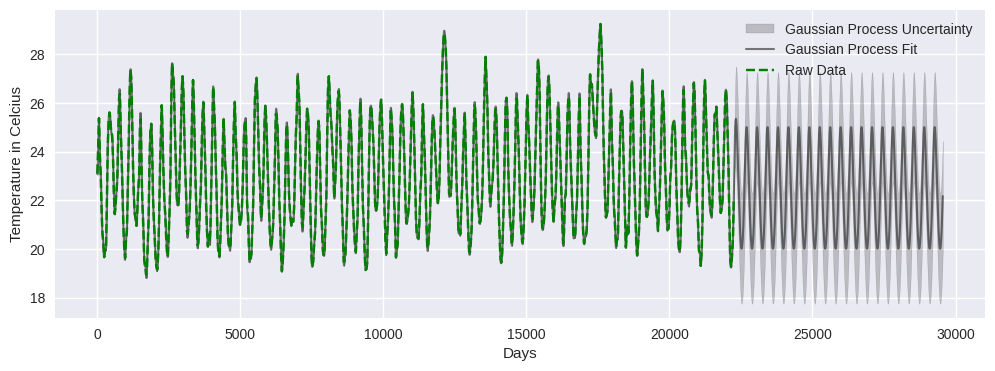

In [ ]:
def visualize_model():
    """
    Visualize your model. Use any method you like in visualizing your model but
    you must make at least one plot with a figure caption. Your
    visualization must also plot the uncertainties from the GP model.

    In your figure caption, comment on the effectiveness of your model in
    predicting temperatures beyond 2010.

    """
    # YOUR CODE HERE

    # Using the initial guess from the optimized output:
    initial_guess = [3.652e2, 1.673e3]
    # Using same setup for the GP
    kernel = np.var(data) * kernels.ExpSquaredKernel(initial_guess[1]) + kernels.ExpSine2Kernel(1.0, np.log(initial_guess[0]))
    # Do magic
    gp = george.GP(kernel)
    gp.compute(t, yerr=0)
    pred_temp, pred_temp_var = gp.predict(data, interp_t, return_var=True)

    # Plot stuff in order to see if it is working
    fig, ax = plt.subplots(figsize=(12,4))
    ax.fill_between(interp_t, pred_temp - np.sqrt(pred_temp_var), pred_temp + np.sqrt(pred_temp_var),
                color="k", alpha=0.2)
    ax.plot(interp_t, pred_temp, "k", lw=1.5, alpha=0.5)
    ax.plot(t, data, '--g')

    plt.legend(["Gaussian Process Uncertainty", "Gaussian Process Fit", "Raw Data"])
    plt.xlabel("Days")
    plt.ylabel("Temperature in Celcius")
    plt.show()





visualize_model()

**Figure 5:** This image shows the output from the Gaussian Process using L2 Optimization. It fits the data almost perfectly but unfortunately it has shortcomings in the future predictions. It does not look to different from the graph before the L2 optimization that we were able to create by playing around with the initial value. It makes sense that its not great at predicting the future since its trained specifically to minimize error on the dataset and not create a generalized solution but rather a very specific one. Perhaps we did this part wrong, or perhaps this is just a shortcoming of the opmizer that we used for this.